# Проект e-commerce: Анализ совершенных покупок в интернет-магазине

In [30]:
import pandas as pd 
import requests 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns
from urllib.parse import urlencode 
from datetime import timedelta
import datetime as dt

###### Загружаем данные

Таблица заказов

In [31]:
# Получаем таблицу с заказами
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/ZhGseD1Wxb77jQ' 
 
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url_orders = response.json()['href'] 
 
# загружаем файл в df 
download_response = requests.get(download_url_orders) 
orders_df = pd.read_csv(download_url_orders, sep=',', parse_dates=['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']) 
orders_df.head(5)

# Статусы:

# created —  создан
# invoiced —  выставлен счёт

# approved —  подтверждён
# processing —  в процессе сборки заказа
# shipped —  отгружен со склада
# delivered —  доставлен пользователю

# unavailable —  недоступен
# canceled —  отменён

# order_purchase_timestamp —  время создания заказа
# order_approved_at —  время подтверждения оплаты заказа
# order_delivered_carrier_date —  время передачи заказа в логистическую службу
# order_delivered_customer_date —  время доставки заказа
# order_estimated_delivery_date —  обещанная дата доставки
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


Таблица товаров

In [32]:
# Получаем таблицу с товарами

# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/G2W6YkBrUDO87A' 
 
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url_items = response.json()['href'] 
 
# загружаем файл в df 
download_response = requests.get(download_url_items) 
items_df = pd.read_csv(download_url_items, sep=',',parse_dates=['shipping_limit_date'])
# shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

items_df.head(5)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


Таблица по клиентам

In [33]:
# Получаем таблицу с клиентами

# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/Pnf8VyFce0uWDA' 
 
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url_clients = response.json()['href'] 
 
# загружаем файл в df 
download_response = requests.get(download_url_clients) 
clients_df = pd.read_csv(download_url_clients, sep=',')

clients_df.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


#### Проведем EDA
основной таблицы с которой будем работать - orders

In [34]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


Есть дыры в timestamp по статусам заказов. Проверим заказы со статусом delivered на n/a в timestamp

In [35]:
orders_df.query('order_status=="delivered"').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96478 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96478 non-null  object        
 1   customer_id                    96478 non-null  object        
 2   order_status                   96478 non-null  object        
 3   order_purchase_timestamp       96478 non-null  datetime64[ns]
 4   order_approved_at              96464 non-null  datetime64[ns]
 5   order_delivered_carrier_date   96476 non-null  datetime64[ns]
 6   order_delivered_customer_date  96470 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96478 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.6+ MB


У заказов со статусом delivered так же в некоторых случаях: 
- 14 заказах нет метки времени в order_approved_at
- 2 заказах нет метки времени в order_delivered_carrier_date
- 8 заказах нет timestamp в поле order_delivered_customer_date

Посмотрим на заказы с точки зрения их фактических статусов в % соотношении

In [36]:
order_status = orders_df.order_status.value_counts(normalize=True).mul(100)
order_status

delivered      97.020344
shipped         1.113223
canceled        0.628513
unavailable     0.612423
invoiced        0.315765
processing      0.302692
created         0.005028
approved        0.002011
Name: order_status, dtype: float64

97% заказов  доставлено клиенту

Посмотрим на описательную статистику времени перехода заказа от статуса к статусу.

In [37]:
orders_df['purchased_approved'] = (orders_df.order_approved_at-orders_df.order_purchase_timestamp)

orders_df['approved_deliveredcarrier'] = (orders_df.order_delivered_carrier_date-orders_df.order_approved_at)
orders_df['deliveredcarrier_deliveredcustomer'] = (orders_df.order_delivered_customer_date - orders_df.order_delivered_carrier_date)

orders_df[['order_id','order_status','purchased_approved','approved_deliveredcarrier','deliveredcarrier_deliveredcustomer']].describe(include='timedelta')

,purchased_approved,approved_deliveredcarrier,deliveredcarrier_deliveredcustomer
count,99281,97644,96475
mean,0 days 10:25:08.739486910,2 days 19:19:15.298850927,9 days 07:55:59.254148743
std,1 days 02:02:16.813098347,3 days 13:11:10.497083683,8 days 18:14:34.522067763
min,0 days 00:00:00,-172 days +18:44:38,-17 days +21:41:31
25%,0 days 00:12:54,0 days 21:00:44,4 days 02:23:55.500000
50%,0 days 00:20:36,1 days 19:38:29.500000,7 days 02:23:40
75%,0 days 14:34:51,3 days 13:55:52.500000,12 days 00:41:55.500000
max,187 days 21:10:50,125 days 18:18:06,205 days 04:35:00


В таблице присутствуют отрицательные значения, что говорит об ошибках внесения данных в бд (об отсутсвии некоторых значений в полях)

Сделаем проверку на последовательность смены статусов по метке времени. Для этого отсортируем df по каждому order_id и метке времени по возрастанию. Проставим шаги последовательности.


In [38]:
orders_by_status = orders_df[['order_id','order_status','order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date']]
order_by_status = orders_by_status.melt(id_vars=['order_id','order_status'], var_name = 'event_name',value_name='event_timestamp')

# сортируем по id и времени
sorted_orders = order_by_status.sort_values(by=['order_id', 'event_timestamp']).copy()
# добавляем шаги событий
sorted_orders['step'] = sorted_orders.groupby('order_id').cumcount() + 1

# добавляем узлы-источники и целевые узлы
# узлы-источники - это сами события
sorted_orders['source'] = sorted_orders['event_name']
# добавляем целевые узлы
sorted_orders['target'] = sorted_orders.groupby('order_id')['source'].shift(-1)
# преобразуем таблицу
df_comp = sorted_orders.drop(['event_name'],axis=1).reset_index(drop=True)


В результате проверки обнаружены ошибки в проставлении timestamp в некоторых заказах. Например order_id=00d2559e61b9a0744a0552c35c5ecccb первое событие по timestamp идет  order_delivered_carrier_date, а не order_purchase_timestamp	

In [39]:
df_comp.query('order_id=="00d2559e61b9a0744a0552c35c5ecccb"')

,order_id,order_status,event_timestamp,step,source,target
1252,00d2559e61b9a0744a0552c35c5ecccb,delivered,2018-06-11 12:05:00,1,order_delivered_carrier_date,order_purchase_timestamp
1253,00d2559e61b9a0744a0552c35c5ecccb,delivered,2018-06-11 12:24:48,2,order_purchase_timestamp,order_approved_at
1254,00d2559e61b9a0744a0552c35c5ecccb,delivered,2018-06-11 13:32:18,3,order_approved_at,order_delivered_customer_date
1255,00d2559e61b9a0744a0552c35c5ecccb,delivered,2018-06-18 16:51:52,4,order_delivered_customer_date,NaN


Преобразуем datedifference в дни и посмотрим на распредления 'approved_deliveredcarrier' и 'deliveredcarrier_deliveredcustomer'

In [40]:
orders_df['approved_deliveredcarrier'] = (orders_df.order_delivered_carrier_date-orders_df.order_approved_at).dt.days
orders_df['deliveredcarrier_deliveredcustomer'] = (orders_df.order_delivered_customer_date - orders_df.order_delivered_carrier_date).dt.days

orders_df.query('approved_deliveredcarrier<0').shape[0]

1359

Мы имеем 1359 количество заказов с нарушенными метками времени. Создадим колонки флаги, чтобы в дальнейшем, при необходимости отсечь такие заказы

In [41]:
orders_df['flag_approved_delivery'] = np.where(orders_df.approved_deliveredcarrier<0,'bad','ok')
orders_df['flag_carrier_customer'] = np.where(orders_df.deliveredcarrier_deliveredcustomer<0,'bad','ok')

Посмотрим на описательную статистику дней, прошедших с момента оплаты до доставки в лог.службу

<Axes: >

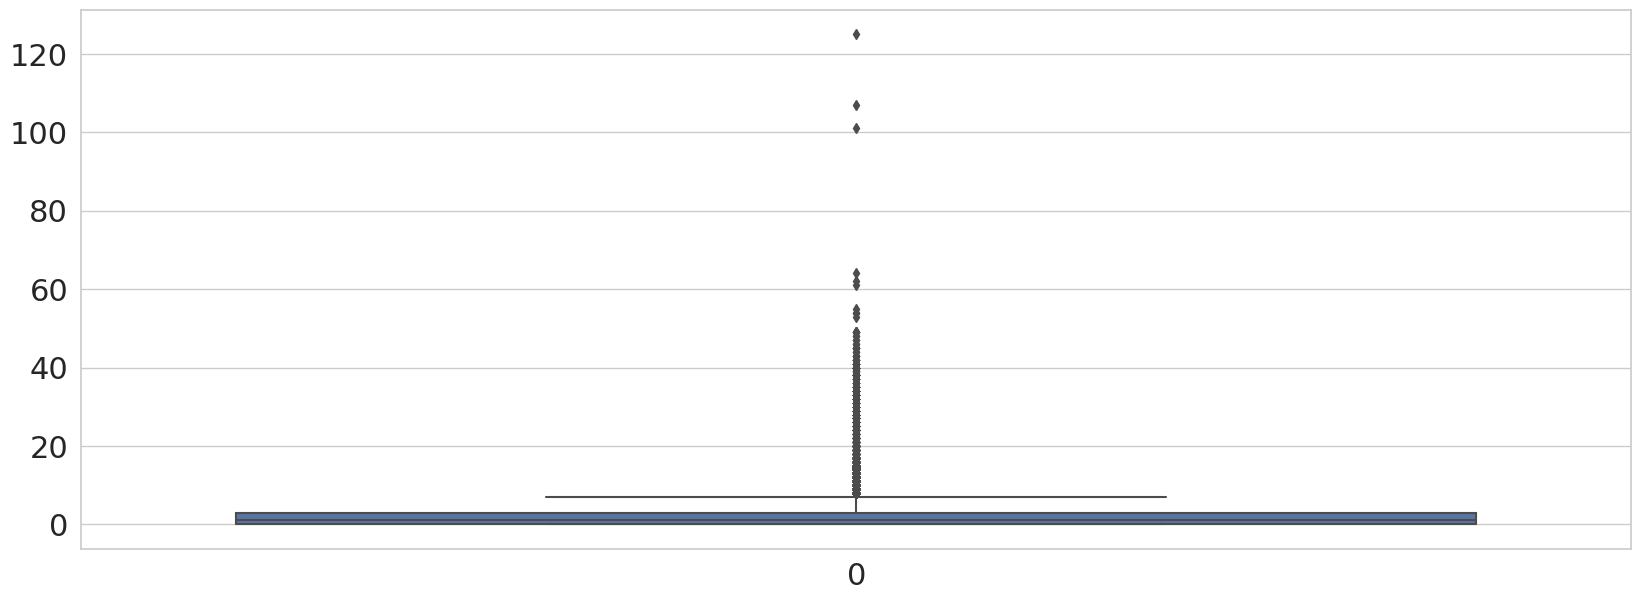

In [42]:
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )
sns.boxplot(orders_df.query('flag_approved_delivery=="ok"').approved_deliveredcarrier)

<Axes: >

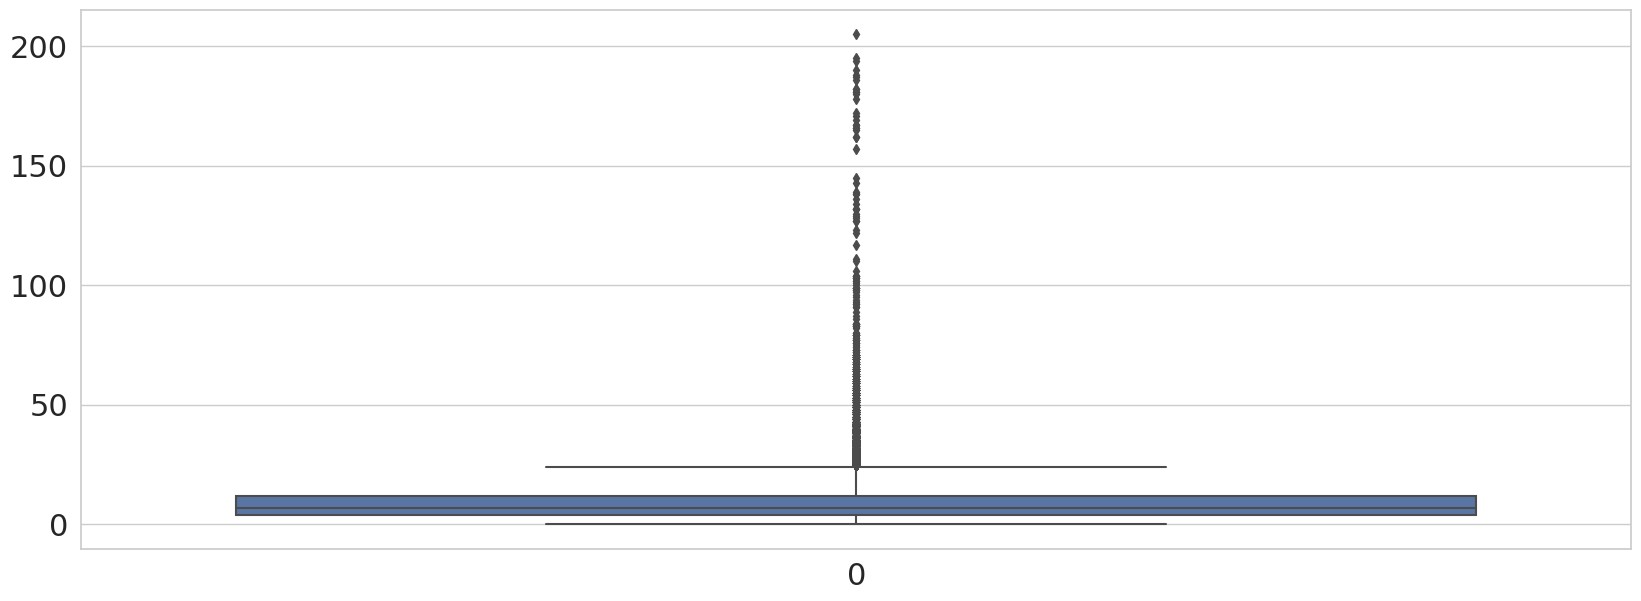

In [43]:
sns.boxplot(orders_df.query('flag_carrier_customer=="ok" & flag_approved_delivery=="ok"').deliveredcarrier_deliveredcustomer)

Рассмотрим аномалии в данных более подробно. 

In [44]:
orders_df['problems']=np.where(
                                (orders_df['order_approved_at']==orders_df['order_approved_at']) & 
                                (orders_df['order_delivered_carrier_date']==orders_df['order_delivered_carrier_date'])&
                                (orders_df['order_delivered_customer_date']!=orders_df['order_delivered_customer_date']),
                                'заказ оплачен находится в лог.службе',
                                np.where(
                                    (orders_df['order_approved_at']!=orders_df['order_approved_at']) & 
                                    (orders_df['order_delivered_customer_date']==orders_df['order_delivered_customer_date']),
                                    'заказ не оплачен но получен',
                                    np.where(
                                        (orders_df['order_delivered_carrier_date']!=orders_df['order_delivered_carrier_date']) & 
                                        (orders_df['order_delivered_customer_date']!=orders_df['order_delivered_customer_date']),
                                        'заказ оплачен но не доставлен в лог.службу',
                                        'заказ оплачен и получен клиентом'
                                        ),
                                )    
                            )                    

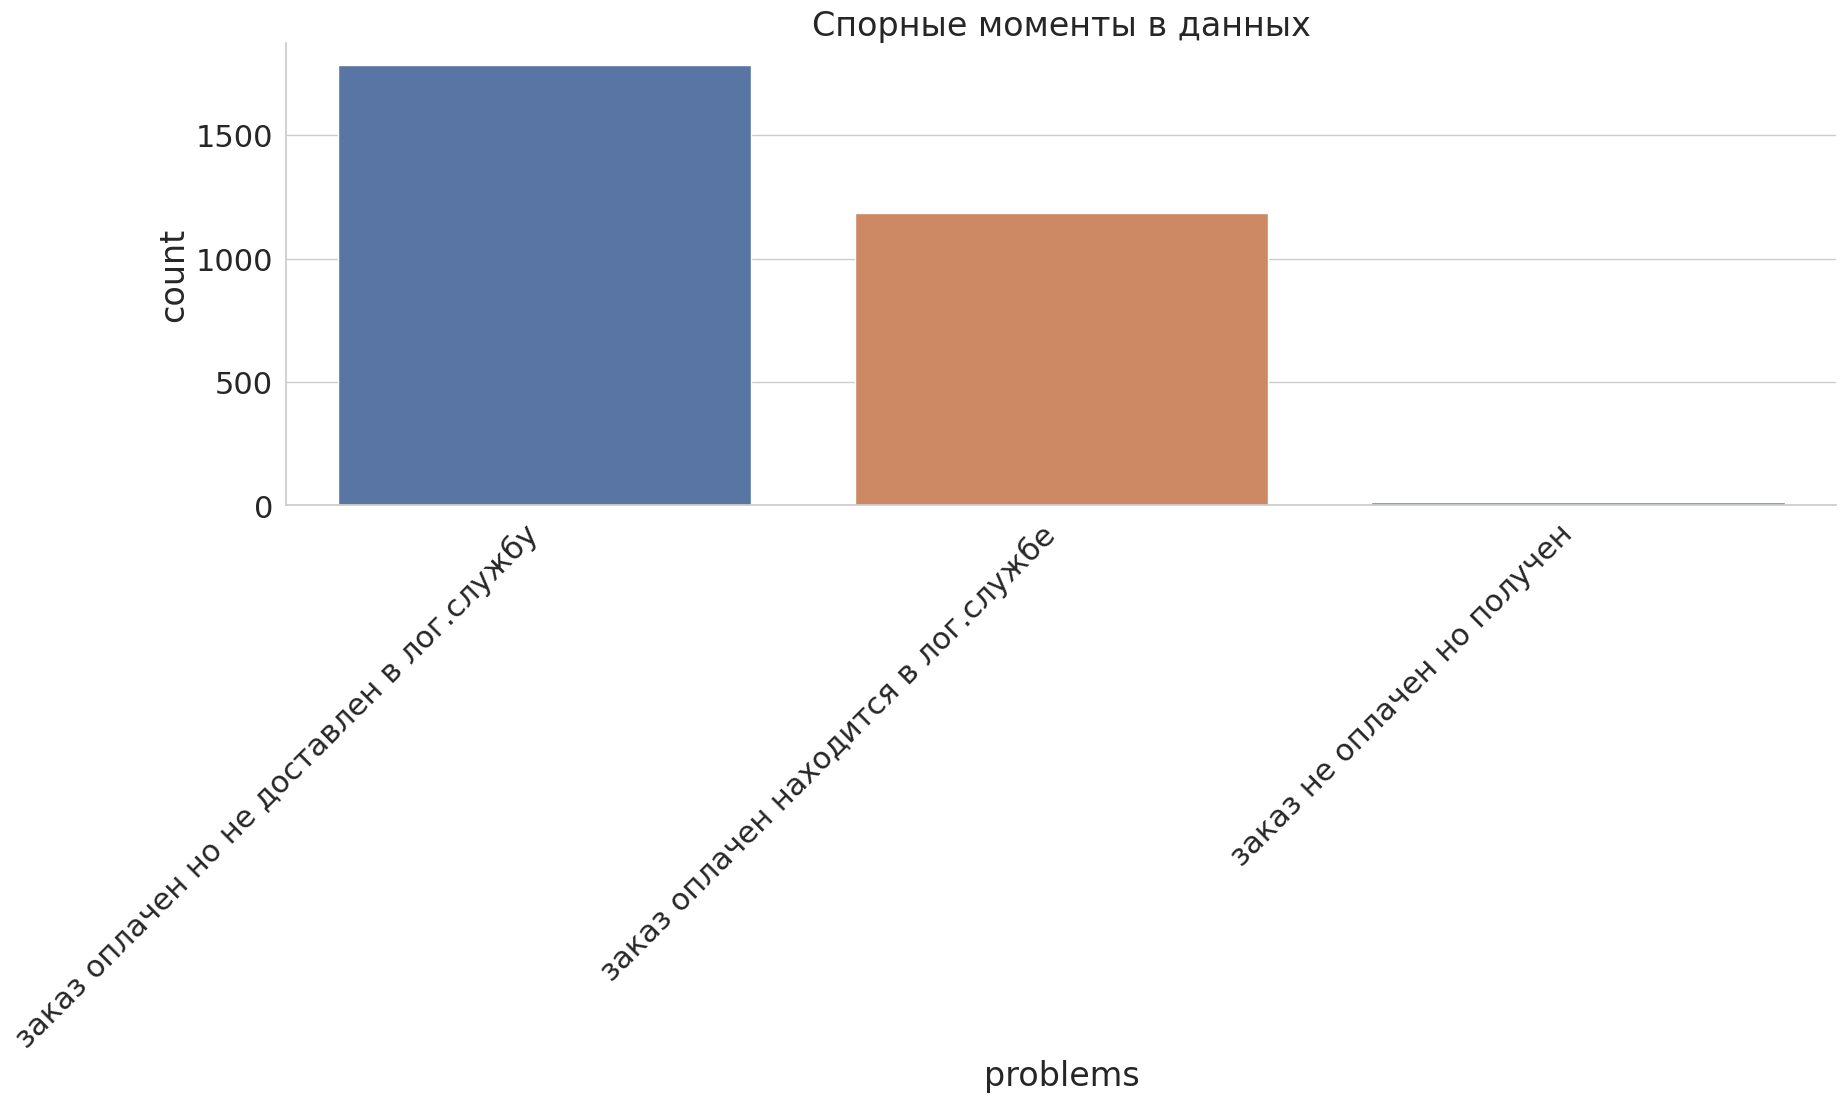

In [45]:
plt.figure(figsize=(20,6))
chart = sns.countplot(x=orders_df.query('problems!="заказ оплачен и получен клиентом"').problems)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_title('Спорные моменты в данных')
sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

###### Вывод: 
В таблице заказов есть противоречения:
- заказ не оплачен, но получен клиентом
- заказ оплачен, но все еще находится в логистической службе
- заказ оплачен, но его нет ни у клиенты ни в логистической службе.

## Вопрос 1. Сколько у нас пользователей, которые совершили покупку только один раз?

Объединяем таблицу orders и customers, чтобы посчитать сколько пользователей заказало всего лишь 1 раз.

In [46]:
all_orders = pd.merge(orders_df, clients_df[['customer_id','customer_unique_id']],how='left',on='customer_id')
customer_orders = all_orders.groupby('customer_unique_id',as_index=False).agg({'order_id':'nunique'}).sort_values('order_id',ascending=False)
'Ответ: ' + str(customer_orders.query('order_id==1').shape[0])

'Ответ: 93099'

## Вопрос 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)

Возьмем заказы со всеми статусами и построим воронку, чтобы понять сколько заказов теряется и на каких этапах (ориентируясь на timestamp).

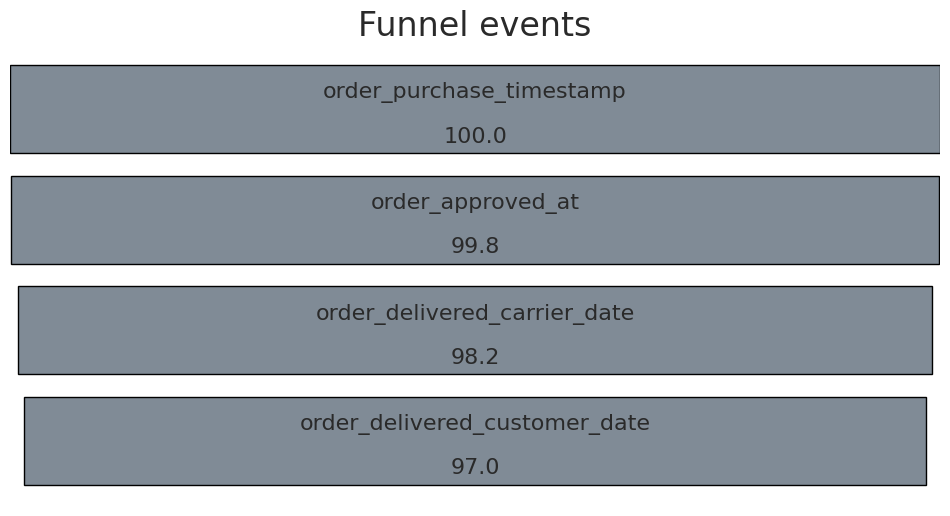

In [47]:
# Готовим данные
count_orders = orders_df.order_id.nunique()

count_order_purchase_timestamp = np.round((orders_df.order_purchase_timestamp.notna().sum()/count_orders*100),1)
count_order_approved_at = np.round(((orders_df.order_approved_at.notna().sum())/count_orders*100),1)
count_order_delivered_carrier_date = np.round(((orders_df.order_delivered_carrier_date.notna().sum())/count_orders*100),1)
count_order_delivered_customer_date = np.round(((orders_df.order_delivered_customer_date.notna().sum())/count_orders*100),1)

# Рисуем воронку

from matplotlib import font_manager as fm
# funnel chart
y = [4,3,2,1]
x = [count_order_purchase_timestamp,count_order_approved_at,count_order_delivered_carrier_date,count_order_delivered_customer_date]
labels = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']
x_max = 100
x_min = 0
x_range = x_max - x_min
fig, ax = plt.subplots(1, figsize=(12,6))
for idx, val in enumerate(x):
    left = (x_range - val)/2
    plt.barh(y[idx], x[idx], left = left, color='#808B96',
             height=.8, edgecolor='black')
    # label
    plt.text(50, y[idx]+0.1, labels[idx], ha='center', 
              fontsize=16, color='#2A2A2A')
    # value
    plt.text(50, y[idx]-0.3, x[idx], ha='center',
              fontsize=16, color='#2A2A2A')
    
plt.xlim(x_min, x_max)
plt.axis('off')
plt.title('Funnel events', loc='center', fontsize=24, color='#2A2A2A')
plt.show()

#### Вывод к графику: 
Как видно из графика от заказа до доставки клиенту теряется примерно 3% заказов.Большая часть (1,5%) на процессе передачи в логистическую службу и (1,2%) из логистической службы клиенту.

Создадим столбец-флаг, который будет сигнализировать о том доставлен ли заказ. И отфильтруем по нему df. Сагрегируем данные по году-месяцу и найдем среднее

In [48]:
orders_df['flag_delivery'] = np.where(orders_df['order_delivered_customer_date']!=orders_df['order_delivered_customer_date'],'not_delivered','delivered')
orders_df['purchase_year_month'] = pd.to_datetime(orders_df['order_purchase_timestamp']).dt.strftime('%Y-%m')
undelivered_df = orders_df.query('flag_delivery=="not_delivered"')
undelivered_yearmonth = orders_df.query('flag_delivery=="not_delivered"').groupby('purchase_year_month',as_index=False).agg(counted=('order_id','nunique'))
mean_by_year_month = undelivered_yearmonth.counted.mean()
# 'В среднем в месяц не доставляется ' + str(mean_by_year_month) + ' заказа'
undelivered_df.head(5)
# df = pd.merge(df,df2[['Key_Column','Target_Column']],on='Key_Column', how='left')
undelivered_df = pd.merge(undelivered_df,items_df[['order_id','price']],on ='order_id',how='left' )

Разберемся в причинах по которым заказы не доставляются.

In [49]:
# Создаем колонку с причинами по которым заказы не доставляеются
undelivered_df['trouble']=np.where(
    (undelivered_df.order_approved_at!=undelivered_df.order_approved_at),
    'заказ не был оплачен',
    (np.where(
        (undelivered_df.order_approved_at==undelivered_df.order_approved_at) & 
        (undelivered_df.price!=undelivered_df.price),
        'оплачен,нет товаров',
        (np.where(
            (undelivered_df.order_delivered_carrier_date!=undelivered_df.order_delivered_carrier_date) & 
            (undelivered_df.price!=undelivered_df.price),
            'заказ не был доставлен в лог.службу',
            (np.where(undelivered_df.order_delivered_carrier_date==undelivered_df.order_delivered_carrier_date,
            'заказ завис в лог.службе',
    'не был доставлен в лог.службу')
        ))))))

In [50]:
troubles_ym = undelivered_df.groupby(['trouble','purchase_year_month']).agg(counted = ('order_id','count'))

troubles = troubles_ym.unstack(level='purchase_year_month').fillna(0)
trouble_means = troubles.mean(axis=1)
trouble_means_df = pd.DataFrame(trouble_means).reset_index()
trouble_means_df = trouble_means_df.rename(columns={0:'means'}).sort_values('means')

''

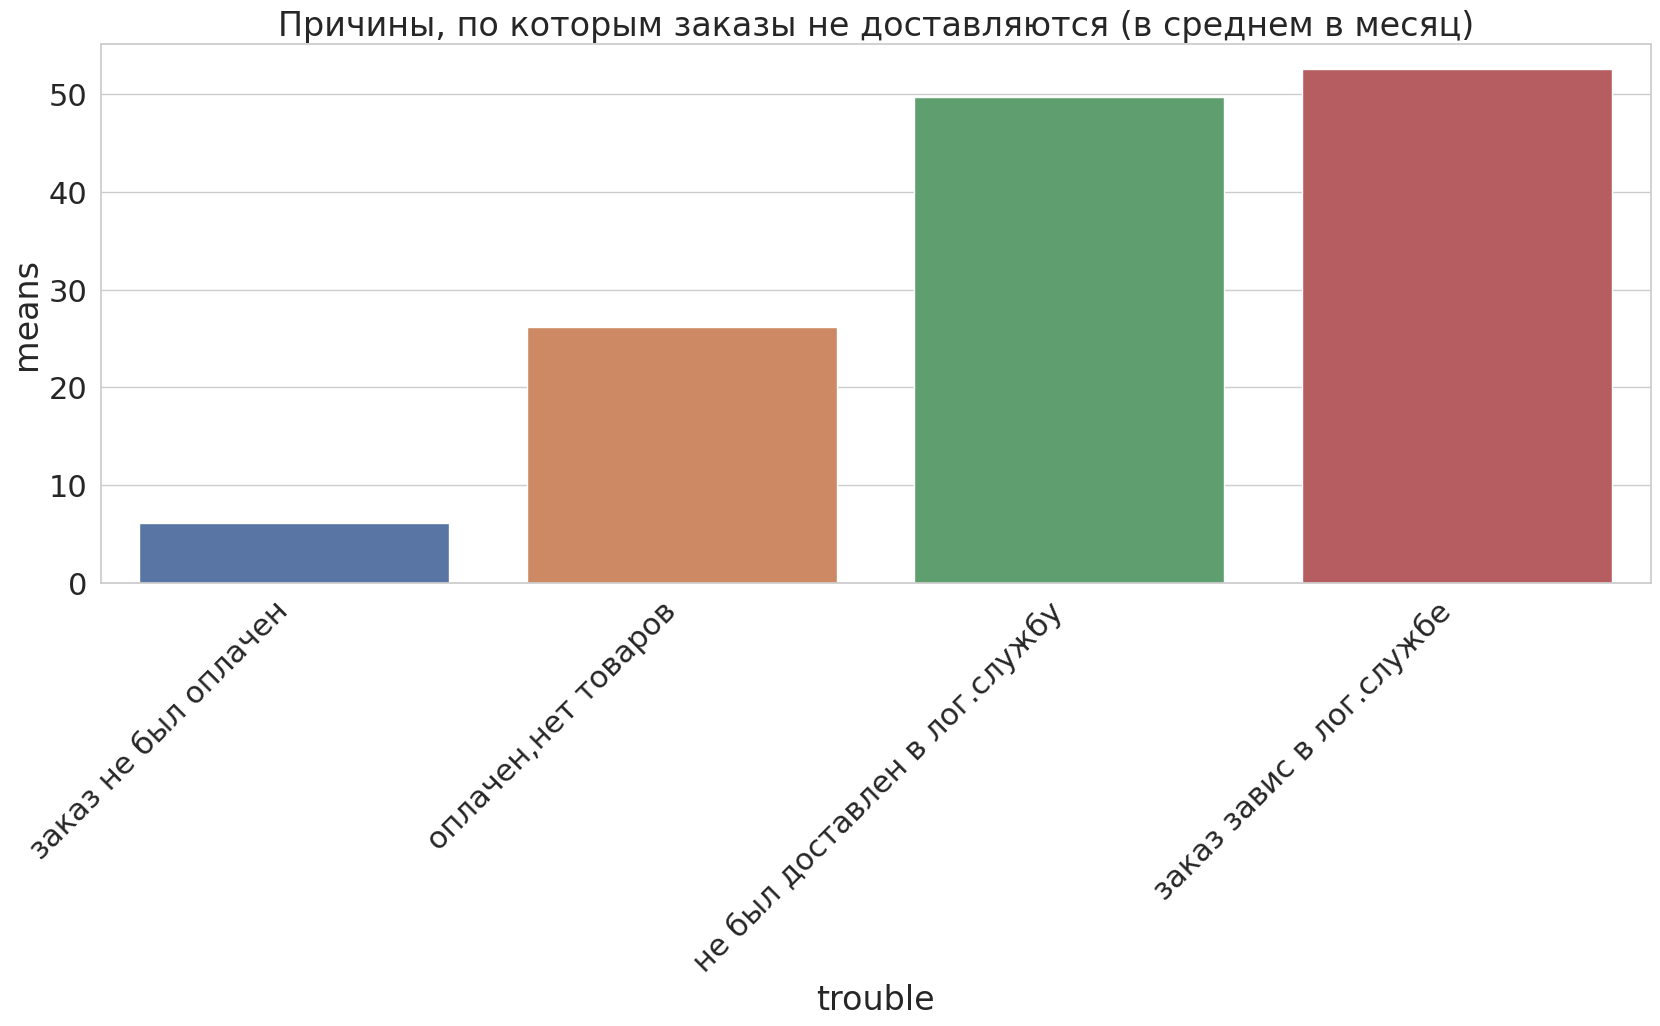

In [51]:
chart = sns.barplot(data = trouble_means_df, x='trouble', y='means')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_title('Причины, по которым заказы не доставляются (в среднем в месяц)')
;

## Вопрос 3. По каждому товару определить, в какой день недели товар чаще всего покупается

День покупки = order_purchase_timestamp. Для решения залачи объединим таблицы orders и items

In [52]:
# К таблице товаров присоединяем столбцы дата подтверждения заказа, чтобы в последствии определить день недели
bought_items = pd.merge(items_df,orders_df[['order_id','order_purchase_timestamp','problems']],how='right',on='order_id')
bought_items['day_name']=bought_items.order_purchase_timestamp.dt.day_name()
# Агрегируем данные по продукту и названию дня недели. С помощью "моды" ищем самые частые дни
days = bought_items[['product_id','day_name']].groupby('product_id',as_index=False).agg({'day_name':pd.Series.mode})

days.head(5).style.set_caption("Задача 3: Дни недели, в которые товар чаще всего покупается")

,product_id,day_name
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,['Friday' 'Wednesday']
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday


Для некоторых товаров имеем несколько best days, потому что их покупали одинаковое количество раз в эти дни, т.е. имеют две моды.

## Вопрос 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели.

In [53]:
pd.options.mode.chained_assignment = None  # default='warn'
# Обрезаем df оставляя только нужные поля
orders_by_customer = all_orders[['order_id','order_purchase_timestamp','customer_unique_id']]
# Считаем количество недель в каждом месяце
orders_by_customer['weeks_in_month'] = np.round(((orders_by_customer.order_purchase_timestamp.dt.daysinmonth)/7),2)
# Приводим дату к формату первое число месяца
orders_by_customer['01_month_year']= (orders_by_customer['order_purchase_timestamp'].apply(lambda x : x.replace(day=1))).dt.date
boughts_by_week = orders_by_customer.groupby(['customer_unique_id','01_month_year','weeks_in_month'], as_index=False).agg(orders=('order_id','nunique'))
# Находим среднее кол-во покупок в неделю в разрезе месяцев
boughts_by_week['means'] = boughts_by_week.orders/boughts_by_week.weeks_in_month
boughts_by_week = boughts_by_week[['customer_unique_id','01_month_year','means']]
boughts_by_week.head(5).style.set_caption("Задача 4: Среднее кол-во покупок в неделю у клиентов по месяцам")

,customer_unique_id,01_month_year,means
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,0.225734
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,0.225734
2,0000f46a3911fa3c0805444483337064,2017-03-01,0.225734
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,0.225734
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,0.233100


## 5. Когортный анализ пользователей. В период с января по декабрь выявить когорту с самым высоким retention на 3й месяц. 

Данные представлены за несколько лет, проверим все ли года полные (имеется информация за все месяцы года) т.к. по заданию нас интересует период с января по декабрь

In [54]:
all_orders['date_purch']=pd.to_datetime(all_orders['order_purchase_timestamp']).dt.strftime('%Y-%m')
all_orders['year']=all_orders['order_purchase_timestamp'].dt.year
all_orders.groupby(['date_purch','year']).agg({'order_id':'count'}).sort_values('date_purch')

,,order_id
date_purch,year,
2016-09,2016,4
2016-10,2016,324
2016-12,2016,1
2017-01,2017,800
2017-02,2017,1780
2017-03,2017,2682
2017-04,2017,2404
2017-05,2017,3700
2017-06,2017,3245


Данные за весь год есть только в 2017. Поэтому отфильтруем df по нему

In [55]:
from operator import attrgetter

# Готовим df к когортному анализу (оставляем только нужные столбцы)
df_to_cohort = all_orders.query('year==2017').copy()
# Преобразуем дату заказа в формат год-месяц-день
df_to_cohort['date']=pd.to_datetime(df_to_cohort['order_purchase_timestamp'].dt.strftime('%Y-%m-%d'))
df_to_cohort['order_month']=pd.to_datetime(df_to_cohort['order_purchase_timestamp']).dt.to_period('M')
df_to_cohort['cohort']= (df_to_cohort.groupby('customer_unique_id')["date"].transform('min')).dt.to_period('M')
df_to_cohort = df_to_cohort[['order_id','order_month','customer_unique_id','cohort']]
df_to_cohort = df_to_cohort.groupby(['cohort', 'order_month']).agg(n_customers=('customer_unique_id', 'nunique')).reset_index(drop=False)
df_to_cohort['period_number'] = (df_to_cohort.order_month - df_to_cohort.cohort).apply(attrgetter('n'))
cohort_pivot = df_to_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')
cohort_size = cohort_pivot.iloc[:,0]
retention = cohort_pivot.divide(cohort_size , axis = 0).round(3)

ur_style = (retention
            .style
            .set_caption('Задача 5: Когортный анализ пользователей')  # добавляем подпись
            .background_gradient(cmap='Reds')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
ur_style

period_number,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2017-01,100.00%,0.40%,0.30%,0.10%,0.40%,0.10%,0.50%,0.10%,0.10%,,0.40%,0.10%
2017-02,100.00%,0.20%,0.30%,0.10%,0.40%,0.10%,0.20%,0.20%,0.20%,0.20%,0.10%,
2017-03,100.00%,0.50%,0.40%,0.40%,0.30%,0.20%,0.20%,0.30%,0.30%,0.10%,,
2017-04,100.00%,0.60%,0.20%,0.20%,0.30%,0.30%,0.30%,0.30%,0.30%,,,
2017-05,100.00%,0.50%,0.50%,0.40%,0.30%,0.30%,0.40%,0.20%,,,,
2017-06,100.00%,0.50%,0.40%,0.40%,0.30%,0.40%,0.40%,,,,,
2017-07,100.00%,0.50%,0.40%,0.30%,0.30%,0.20%,,,,,,
2017-08,100.00%,0.70%,0.30%,0.30%,0.40%,,,,,,,
2017-09,100.00%,0.70%,0.50%,0.30%,,,,,,,,


Находим когорту с самым высоким retention на 3й месяц

In [56]:
maximum = retention[3].max()
retention.loc[retention[3]==maximum][3]

cohort
2017-03    0.004
2017-05    0.004
2017-06    0.004
Freq: M, Name: 3, dtype: float64

## 6. RFM-сегментация пользователей 
R - время от последней покупки пользователя до текущей даты, 
F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю.

In [57]:
sum_f_orders=items_df.groupby('order_id',as_index=False).agg({'price':'sum'})
# Получаем df c суммами по заказам
# Пристыковываем суммы по заказам к основной df
all_orders = pd.merge(all_orders,sum_f_orders[['order_id','price']],how='left',on='order_id')

In [58]:
# Оставляем только нужные колонки из df
orders_to_rfm = all_orders[['order_id','customer_unique_id','order_purchase_timestamp','price']].copy()
# Создаем колонку последней даты, относительно нее будем считать Recency
now = orders_to_rfm.order_purchase_timestamp.max()+timedelta(days=1)
# Для каждого заказа считаем кол-во прошедших дней
orders_to_rfm['days_since_order'] = orders_to_rfm['order_purchase_timestamp'].apply(lambda x: (now - x).days)
# Группируем df по клиенту и рассяитываем r-f-m
# Recency - время от последней покупки до текущей даты (now)
# Frequency - кол-во заказов на пользователя
# Monetary - сумма от всех заказов клиента
rfm_df = orders_to_rfm.groupby('customer_unique_id', as_index=False)\
                        .agg(recency=('days_since_order','min'),frequency = ('order_id','nunique'),monetary = ('price','sum'))\
                        .reset_index()
# Для разделения в Recency и Monetary используем qcut , чтобы разделить базовые данные на интервалы равного размера. Эта Функция определяет интервалы с использованием
# процентилей на основе распределения данных, а не фактических числовых границ интервалов.

In [59]:
# Для разделения в Recency и Monetary используем qcut , чтобы разделить базовые данные на интервалы равного размера. Эта Функция определяет интервалы с использованием
# процентилей на основе распределения данных, а не фактических числовых границ интервалов.

labels_r = ['0-143','144-228','229-318','319-434','более 434']
rfm_df['q_r']=pd.qcut(rfm_df['recency'], q=5, precision=0,labels = labels_r)

labels_m = ['0-39','40-69','70-110','111-180','более 180']
rfm_df['q_m']= pd.qcut(rfm_df['monetary'], q=5, precision=0,labels = labels_m)

# # Для разделения в Frequency будем использовать метод pd.cut с пользовательскими bins, потому что данные нельзя поделить на 
# # интервалы равного размера.
labels_f = ['1', '2','3', '5', 'более 5']
cut_bins = [0, 1, 2, 3, 5, 15]
rfm_df['q_f'] = pd.cut(rfm_df['frequency'], bins=cut_bins, labels = labels_f)

In [60]:
# Теперь присвоим ранги нашим группам по (q_r,q_m,q_f) 
# от 1 до 4. Чем меньше значение Recency, тем лучше, тогда как более высокие значения Frequency и Monetary лучше. 
rfm_df['R'] = np.where(rfm_df['q_r']== '0-143','5',
                       np.where(rfm_df['q_r']=='144-228',
                        '4',
                            np.where(rfm_df['q_r']=='229-318',
                            '3',
                                np.where(rfm_df['q_r']=='319-434','2',
                                         np.where(rfm_df['q_r']=='более 434','1','False'))))
                      
                      )
rfm_df['M'] = np.where(rfm_df['q_m']== '0-39','1',
                       np.where(rfm_df['q_m']=='40-69',
                        '2',
                            np.where(rfm_df['q_m']=='70-110',
                            '3',
                                np.where(rfm_df['q_m']=='111-180','4',
                                         np.where(rfm_df['q_m']=='более 180','5','False'))))
                      
                      )
rfm_df['F'] = np.where(rfm_df['q_f']== '1','1',
                       np.where(rfm_df['q_f']=='2',
                        '2',
                            np.where(rfm_df['q_f']=='3',
                            '3',
                                np.where(rfm_df['q_f']=='5','4',
                                         np.where(rfm_df['q_f']=='более 5','5',
                                         'False'))))
                      
                      )
# Создаем колонку общего рейтинга
rfm_df['RFM_score']= rfm_df.R.astype('str') + rfm_df.F.astype('str') + rfm_df.M.astype('str')

rfm_df.head(5)

,index,customer_unique_id,recency,frequency,monetary,q_r,q_m,q_f,R,M,F,RFM_score
0,0,0000366f3b9a7992bf8c76cfdf3221e2,161,1,129.90,144-228,111-180,1,4,4,1,414
1,1,0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,18.90,144-228,0-39,1,4,1,1,411
2,2,0000f46a3911fa3c0805444483337064,586,1,69.00,более 434,40-69,1,1,2,1,112
3,3,0000f6ccb0745a6a4b88665a16c9f078,370,1,25.99,319-434,0-39,1,2,1,1,211
4,4,0004aac84e0df4da2b147fca70cf8255,337,1,180.00,319-434,более 180,1,2,5,1,215


In [61]:
# Создадим справочник с описанием групп клиентов на основе R и F рейтинга. Названия сегментов взято 
# из https://guillaume-martin.github.io/rfm-segmentation-with-python.html
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

rfm_df['Segment'] = rfm_df['R'].map(str) + rfm_df['F'].map(str)
rfm_df['Segment'] = rfm_df['Segment'].replace(segt_map, regex=True)
rfm_df.head()

,index,customer_unique_id,recency,frequency,monetary,q_r,q_m,q_f,R,M,F,RFM_score,Segment
0,0,0000366f3b9a7992bf8c76cfdf3221e2,161,1,129.90,144-228,111-180,1,4,4,1,414,promising
1,1,0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,18.90,144-228,0-39,1,4,1,1,411,promising
2,2,0000f46a3911fa3c0805444483337064,586,1,69.00,более 434,40-69,1,1,2,1,112,hibernating
3,3,0000f6ccb0745a6a4b88665a16c9f078,370,1,25.99,319-434,0-39,1,2,1,1,211,hibernating
4,4,0004aac84e0df4da2b147fca70cf8255,337,1,180.00,319-434,более 180,1,2,5,1,215,hibernating


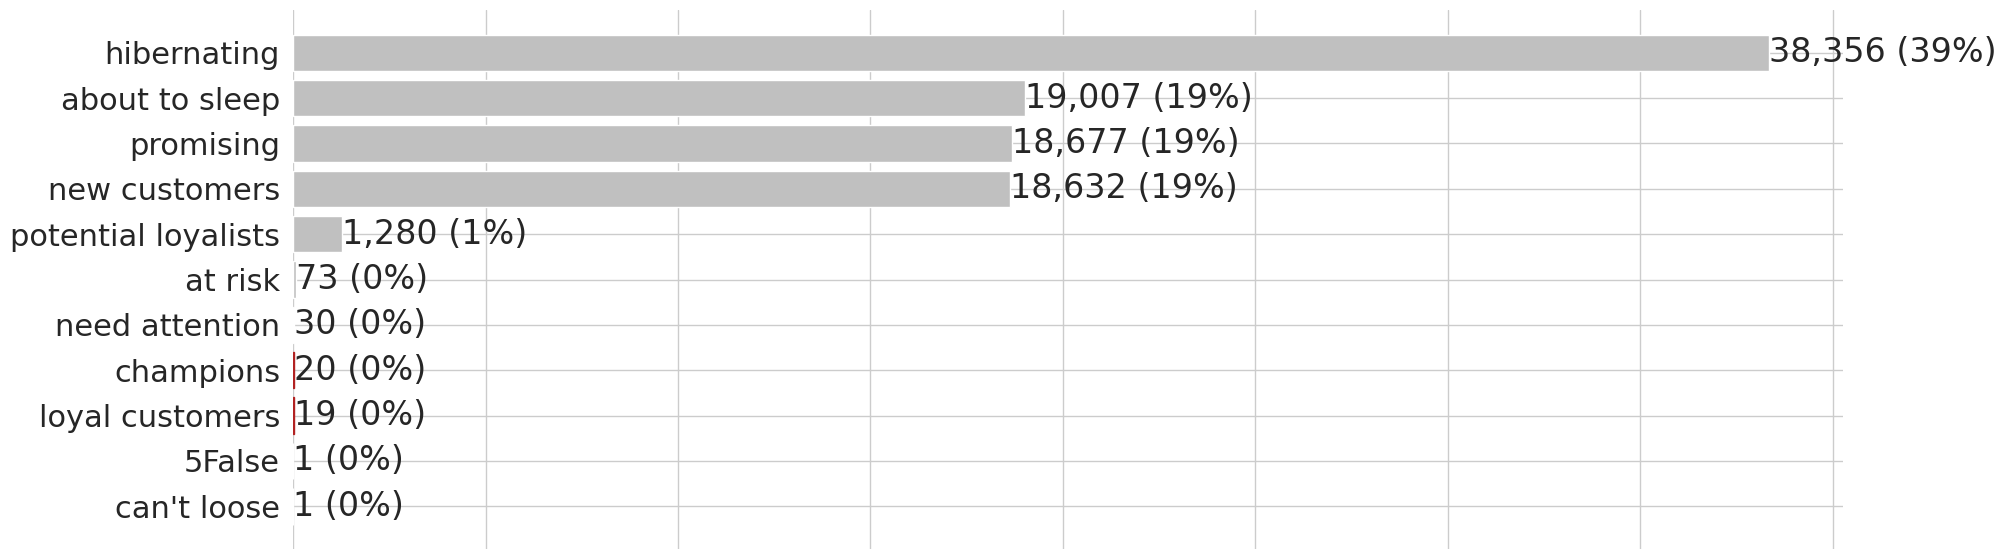

In [62]:
# Визуализируем количество клиентов по сегментам
segments_counts = rfm_df['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()